In [1]:
# Import libraries and setup matplotlib defaults
from matplotlib import pyplot as pl
import pandas as pd
import numpy as np
pl.style.use('bmh')
clist = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
         '#ffff33', '#a65628', '#f781bf', '#999999']
prop_cycle = pl.cycler(color=clist)
pl.rcParams.update({
    'axes.prop_cycle': prop_cycle,
    'lines.linewidth': 2,
    'font.size': 20,
    'figure.figsize': [12, 8],
    'figure.subplot.left': 0.125,
    'figure.subplot.right': 0.95,
    'figure.subplot.bottom': 0.15})

In [2]:
import sys
sys.path.append('../')
from data_utils import *

md = load_membership_data()
td = load_temple_data()

# deal with cases where no groundbreaking is listed, because groundbreaking date is used later
missing_gr = td['Groundbreaking date'].isna() & ~td['Dedication date'].isna()
td.loc[missing_gr, 'Groundbreaking date'] = td[missing_gr]['Dedication date'] - np.timedelta64(3, 'Y')

# for this analysis, exclude temple temples that won't be built
exclude = ['Efforts halted in 1830s', 'Efforts suspended in 2006', 'Historic site', 'Destroyed']
td = td[~td['Status'].isin(exclude)]

In [3]:
most_common_size_count = td.value_counts('area').iloc[0]

# Area categories
td['area_cat'] = ''
td.loc[td['area']>0, 'area_cat'] = '0-12000'
td.loc[td['area']>12000, 'area_cat'] = '12000-20000'
td.loc[td['area']>20000, 'area_cat'] = '20000-30000'
td.loc[td['area']>30000, 'area_cat'] = '30000-40000'
td.loc[td['area']>40000, 'area_cat'] = '40000-50000'
td.loc[td['area']>50000, 'area_cat'] = '50000-70000'
td.loc[td['area']>70000, 'area_cat'] = '70000-100000'
td.loc[td['area']>100000, 'area_cat'] = '100000+'

# Dedication decade
td['ded_dec'] = 'future'
td.loc[td['Dedication date'].dt.year>0, 'ded_dec'] = 'earlier'
td.loc[td['Dedication date'].dt.year>=1980, 'ded_dec'] = '1980s'
td.loc[td['Dedication date'].dt.year>=1990, 'ded_dec'] = '1990s'
td.loc[td['Dedication date'].dt.year>=2000, 'ded_dec'] = '2000s'
td.loc[td['Dedication date'].dt.year>=2010, 'ded_dec'] = '2010s'
td.loc[td['Dedication date'].dt.year>=2020, 'ded_dec'] = '2020s'

# region categories
td['reg_cat'] = 'non-US'
td.loc[td['Country']=='United States', 'reg_cat'] = 'other US'
td.loc[td['Region'].isin(['Utah', 'Idaho', 'Arizona']), 'reg_cat'] = 'UT/ID/AZ'

#td['area_cat'].value_counts().sort_index()
#td.value_counts('ded_dec').sort_index()
#td['reg2'].value_counts()

In [4]:
# For projecting future costs, estimate sizes of announced temples. Small, medium, and large
# temples are assigned to be 10,000, 20,000, and 30,000 square feet. Most of the temples are
# presumed to be small, including all of those in Europe and Asia. A few are presumed medium
# based on being near large population centers in countries with large church membership.
small_temple_list = [
    'Managua Nicaragua Temple',
    'Budapest Hungary Temple',
    'Dubai United Arab Emirates Temple',
    'Oslo Norway Temple',
    'Brussels Belgium Temple',
    'Vienna Austria Temple',
    'Singapore Republic of Singapore Temple',
    'Kaohsiung Taiwan Temple',
    'Tacloban City Philippines Temple',
    'Cagayan de Oro Philippines Temple',
    'Urdaneta Philippines Temple',
    'Alabang Philippines Temple',
    'Cody Wyoming Temple',
    'Culiacán Mexico Temple',
    'Vitória Brazil Temple',
    'Belém Brazil Temple',
    'Antananarivo Madagascar Temple',
    'Santa Cruz Bolivia Temple',
    'Lagos Nigeria Temple',
    'Benin City Nigeria Temple',
    'Kumasi Ghana Temple',
    'Beira Mozambique Temple',
    'Monrovia Liberia Temple',
    'Nairobi Kenya Temple',
    'Abidjan Ivory Coast Temple',
    'San Juan Puerto Rico Temple',
    'Kananga Democratic Republic of the Congo Temple',
    'Auckland New Zealand Temple',
    'Wellington New Zealand Temple',
    'Brazzaville Republic of the Congo Temple',
    'Barcelona Spain Temple',
    'Birmingham England Temple',
    'Cusco Peru Temple',
    'San Luis Potosí Mexico Temple',
    'Mexico City Benemérito Mexico Temple',
    'Tampa Florida Temple',
    'Knoxville Tennessee Temple',
    'Missoula Montana Temple',
    'Modesto California Temple',
    'Busan Korea Temple',
    'Naga Philippines Temple',
    'Santiago Philippines Temple',
    'Eket Nigeria Temple',
    'Chiclayo Peru Temple',
    'Buenos Aires City Center Argentina Temple',
    'Huehuetenango Guatemala Temple',
    'Jacksonville Florida Temple',
    'Grand Rapids Michigan Temple',
    'Lone Mountain Nevada Temple',
    'Tacoma Washington Temple',
    'Cuernavaca Mexico Temple',
    'Pachuca Mexico Temple',
    'Toluca Mexico Temple',
    'Tula Mexico Temple']

medium_temple_list = [
    'Quito Ecuador Temple',
    'Lima Peru Los Olivos Temple',
    'Salta Argentina Temple',
    'São Paulo East Brazil Temple',
    'Santiago West Chile Temple',
    'Fort Worth Texas Temple',
    'Cleveland Ohio Temple',
    'Wichita Kansas Temple',
    'Austin Texas Temple',
    'Maceió Brazil Temple',
    'Santos Brazil Temple',
    'Londrina Brazil Temple',
    'Ribeirão Preto Brazil Temple',
    'Prosper Texas Temple']

large_temple_list = [
    'La Paz Bolivia Temple']

even_larger_list = []

who_knows_if_it_will_get_built_list = [
    'Russia Temple',
    "Shanghai People's Republic of China Temple"]

# Check whether items need to be added or removed
combined_list = small_temple_list+medium_temple_list+large_temple_list+even_larger_list+ \
            who_knows_if_it_will_get_built_list
no_area = td['area'].isna()
in_lists = td['Name'].isin(combined_list)
to_add_to_lists = td[no_area & ~in_lists]['Name'].to_list()
to_remove_from_lists = td[in_lists & ~no_area]['Name'].to_list()

if len(to_add_to_lists):
    print('need to add to lists:')
    print(to_add_to_lists)

if len(to_remove_from_lists):
    print('need to remove from lists:')
    print(to_remove_from_lists)
    print(td[td['Name'].isin(to_remove_from_lists)][['Name', 'area']])


td.loc[td['Name'].isin(small_temple_list), 'area'] = 10000
td.loc[td['Name'].isin(medium_temple_list), 'area'] = 20000
td.loc[td['Name'].isin(large_temple_list), 'area'] = 30000
td.loc[td['Name'].isin(even_larger_list), 'area'] = 40000

td['area_estimated'] = 0
td.loc[td['Name'].isin(small_temple_list+medium_temple_list+large_temple_list), 'area_estimated'] = 1

# estimate site size for temples that don't have lots yet.
# based on previous averages, small:3 acres, medium: 6 acres, large: 10 acres
lot_dict = {10000:3, 20000:6, 30000:10, 40000:10}
site_idx = td['site'].isna() & ~td['area'].isna()

td[site_idx][['Name', 'area', 'Announcement date']]
td['site_estimated'] = 0
td.loc[site_idx, 'site_estimated'] = 1

td.loc[site_idx, 'site'] = td[site_idx]['area'].replace(lot_dict)

The following is some analysis of the temple data found on this [Wikipedia page](https://en.wikipedia.org/wiki/Comparison_of_temples_of_The_Church_of_Jesus_Christ_of_Latter-day_Saints). The data were extracted into a table using this [online tool](https://wikitable2csv.ggor.de/).

## Temple construction time
The chart below illustrates the rate at which temples are started and completed after they are announced. As of 2021, the most recent year for which all temples announced in that year have been completed is 2012, and the most recent year for which all announced temples have been started is 2017. These data points suggest that there can be a delay of up to 4 years to groundbreaking from announcement, and another 5 years to dedication after groundbreaking. The average times for these are a little less than that, but more than 3 years in both cases. On the other hand, ground has already been broken on a handful of temples announced in both 2020 and 2021.

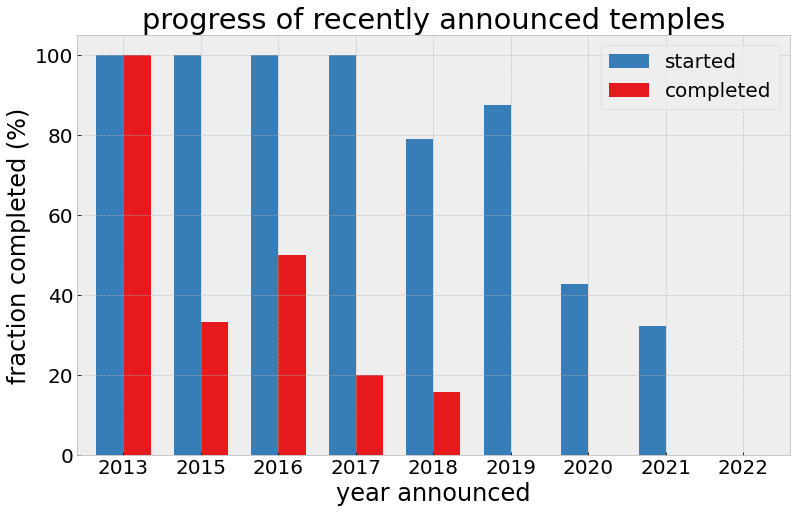

In [5]:
an_cmpl = td['Announcement date'].dt.year.to_frame('year announced').assign(
    started=(~td['Groundbreaking date'].isna()).astype(int).to_frame('started'),
    completed=(~td['Dedication date'].isna()).astype(int).to_frame('completed'))

plotdata = an_cmpl.groupby('year announced').mean()
ax = (plotdata[plotdata.index>=2013]*100).plot.bar(
    title='progress of recently announced temples',
    rot=0, width=0.7, ylabel='fraction completed (%)')

In [6]:
# Use temples completed since 2008 as a reference for estimating planning and construction time
# set minimum date for estimated grounbreaking and dedication so they aren't in the past
min_date = pd.to_datetime('2022-07-01')

ref_temples = td[(td['Announcement date'].dt.year>=2008) & (~td['Dedication date'].isna())]
est_times = ref_temples[['Announcement date', 'Groundbreaking date',
                         'Dedication date']].diff(axis=1).mean()

gr_est = td['Groundbreaking date'].isna()
td.loc[gr_est, 'Groundbreaking date'] = td[gr_est][
    'Announcement date'] + est_times['Groundbreaking date']
idx = gr_est & (td['Groundbreaking date'] < min_date)
td.loc[idx, 'Groundbreaking date'] = min_date

de_est = td['Dedication date'].isna()
td.loc[de_est, 'Dedication date'] = td[de_est][
    'Groundbreaking date'] + est_times['Dedication date']
idx = de_est & (td['Dedication date'] < min_date)
td.loc[idx, 'Dedication date'] = min_date

td['completion_estimated'] = 0
td.loc[de_est, 'completion_estimated'] = 1

## Size of temples over time
The chart below shows the size (in square feet) of every temple built since 1950. The largest, Los Angeles, at over 190,000 square feet is by far the largest temple built since its completion. Only the Salt Lake temple is larger (250,000 square feet), but it includes a good deal of space that is not used as a temple in the way that the others are.

The pattern over time has been a steady decline in size of temples, even well before the advent of the "mini temple" that was built in large numbers starting in 1998. Only a handful of temples larger than 100,000 square feet have ever been built, with the most recent one Mt. Timpanogos in the 1990s. A notable exception is the massive new 130,000 square foot Teton River temple currently under construction, the largest temple built in 40 years. The most common size of a temple is 10,700 square feet, based on a design introduced in 1998 and still used frequently to this day. At this time a total of 32 temples are this size. For comparison, a typical church meetinghouse in North America is around 15,000 square feet. Almost no temples larger than 40,000 square feet have been built outside the mountain west (Utah, Idaho, and Arizona) in the last 20 years. So, while the number of new temples announced has increased substantially in the last few years, particularly since Russell M. Nelson became president of the church, most of them are much smaller than the temples of the past. This detail is significant when examining how much the temple building program might cost.

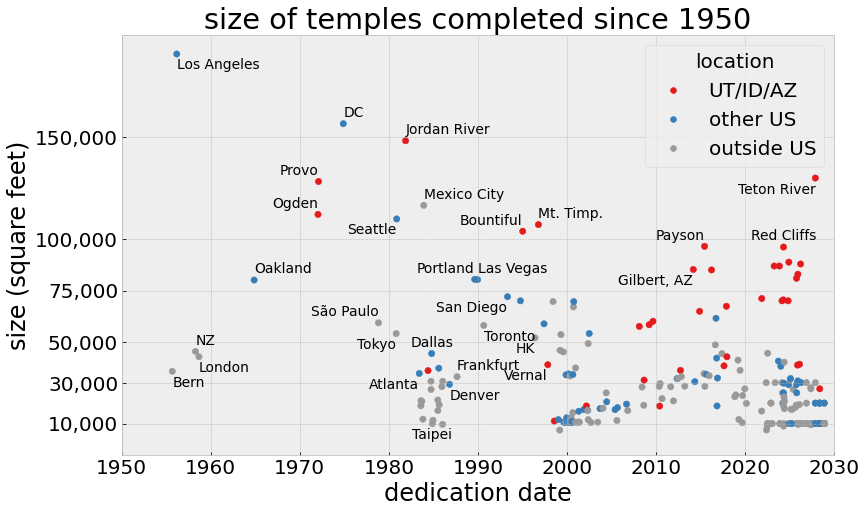

In [7]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap([clist[1], clist[0], clist[8]])

td_ = td[~td['area'].isna()]
idict = {'UT/ID/AZ': 0, 'other US': 1, 'non-US': 2}
idx = np.array([idict[r] for r in td_['reg_cat']])

sc = pl.scatter(td_['Dedication date'], td_['area'], c=idx, cmap=cmap, s=40)
pl.yticks([1e4,3e4,5e4,7.5e4,1e5,1.5e5], ['10,000', '30,000', '50,000', '75,000', '100,000', '150,000'])
pl.ylabel('size (square feet)')
pl.xlabel('dedication date')
pl.xlim([pd.to_datetime('1950-01-01'), pd.to_datetime('2030-01-01')])
pl.ylim(ymax=200000)
pl.legend(sc.legend_elements()[0], ['UT/ID/AZ', 'other US', 'outside US'], title='location')
pl.title('size of temples completed since 1950')

# Annotations
if True:
    labeldata = [
        ('Los Angeles California Temple', 'Los Angeles', 'left', 'top'),
        ('Bern Switzerland Temple', 'Bern', 'left', 'top'),
        ('London England Temple', 'London', 'left', 'top'),
        ('Hamilton New Zealand Temple', 'NZ', 'left', 'bottom'),
        ('Oakland California Temple', 'Oakland', 'left', 'bottom'),
        ('Jordan River Utah Temple', 'Jordan River', 'left', 'bottom'),
        ('Provo Utah Temple', 'Provo', 'right', 'bottom'),
        ('Ogden Utah Temple', 'Ogden', 'right', 'bottom'),
        ('Washington D.C. Temple', 'DC', 'left', 'bottom'),
        ('Bountiful Utah Temple', 'Bountiful', 'right', 'bottom'),
        ('Mount Timpanogos Utah Temple', 'Mt. Timp.', 'left', 'bottom'),
        ('Payson Utah Temple', 'Payson', 'right', 'bottom'),
        ('Red Cliffs Utah Temple', 'Red Cliffs', 'center', 'bottom'),
        ('Mexico City Mexico Temple', 'Mexico City', 'left', 'bottom'),
        ('Seattle Washington Temple', 'Seattle', 'right', 'top'),
        ('Dallas Texas Temple', 'Dallas', 'center', 'bottom'),
        ('Atlanta Georgia Temple', 'Atlanta', 'right', 'top'),
        ('Denver Colorado Temple', 'Denver', 'left', 'top'),
        ('Frankfurt Germany Temple', 'Frankfurt', 'left', 'bottom'),
        ('Portland Oregon Temple', 'Portland', 'right', 'bottom'),
        ('Las Vegas Nevada Temple', 'Las Vegas', 'left', 'bottom'),
        ('São Paulo Brazil Temple', 'São Paulo', 'right', 'bottom'),
        ('Tokyo Japan Temple', 'Tokyo', 'right', 'top'),
        ('Taipei Taiwan Temple', 'Taipei', 'center', 'top'),
        ('Toronto Ontario Temple', 'Toronto', 'left', 'top'),
        ('Vernal Utah Temple', 'Vernal', 'right', 'top'),
        ('San Diego California Temple', 'San Diego', 'right', 'top'),
        ('Hong Kong China Temple', 'HK', 'right', 'top'),
        ('Gilbert Arizona Temple', 'Gilbert, AZ', 'right', 'top'),
        ('Teton River Idaho Temple', 'Teton River', 'right', 'top')]

    ax = pl.gca()
    for label, shortlabel, halign, valign in labeldata:
        data = td_[td_['Name']==label][['Dedication date', 'area']].iloc[0].copy()
        if valign=='top':
            data['area'] -= 2000
        else:
            data['area'] += 2000
        ax.annotate(shortlabel, data, size='x-small', ha=halign, va=valign)


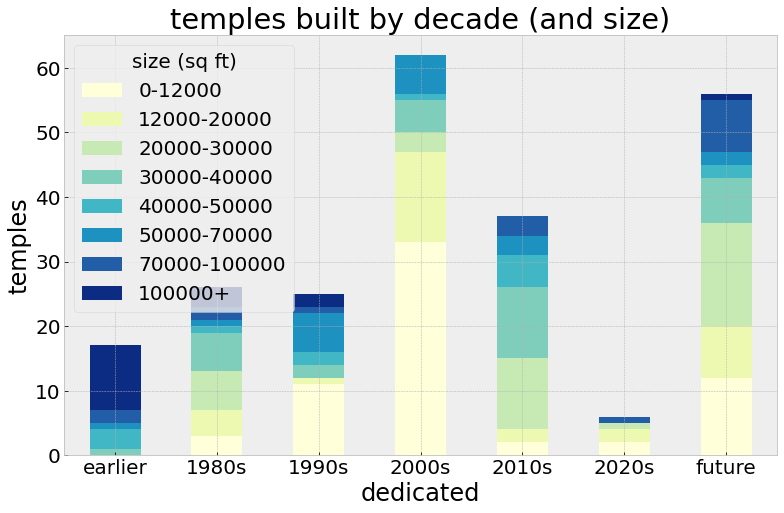

In [8]:
ded_size_table = td.groupby(['area_cat', 'ded_dec']).size().reset_index().pivot(
    columns='area_cat', index='ded_dec').fillna(0)
ded_size_table = ded_size_table.loc[
    ['earlier', '1980s', '1990s', '2000s', '2010s', '2020s', 'future']]
ded_size_table.columns = ded_size_table.columns.get_level_values(1)
ded_size_table = ded_size_table[
    ['0-12000', '12000-20000', '20000-30000', '30000-40000',
     '40000-50000', '50000-70000', '70000-100000', '100000+']]
ded_size_table.columns.name = 'size (sq ft)'

clist2 = ['#ffffd9', '#edf8b1', '#c7e9b4', '#7fcdbb',
          '#41b6c4', '#1d91c0', '#225ea8', '#0c2c84']
mod_props = {'axes.prop_cycle': pl.cycler(color=clist2)}

with pl.rc_context(mod_props):
    _ = ded_size_table.plot.bar(stacked=True, rot=0,
                                ylabel='temples', xlabel='dedicated',
                                title='temples built by decade (and size)')

## Construction cost
In order to estimate construction costs of the temple building program, the primary reference points are the size of the structure in square feet, and the size of the land. In quite a few cases for the most recently announced temples, these data points are missing, so they must be filled in with educated guesses in order to get the most realistic cost estimate.

Guessing temple and lot sizes was done with the following assumptions:
 - nearly all temples outside the US, particularly Africa and Asia, are assumed to be 10,000 square feet, based on construction patterns in those regions in the last 20 years.
 - a handful of temples were assumed to be slightly larger, either 20,000 or 30,000 square feet if they were near large population centers in countries with relatively large numbers of church members, based on typical sizes of existing temples in those countries. This includes several temples in various South American countries.
 - Announced temples in Russia and China have been omitted due to ongoing uncertainty over whether they are likely to be built any time soon.
 - Land sizes were set at 3, 6, or 10 acres depending on the temple size, in line with patterns in the data for existing temples.

The two key assumptions for computing costs were a land price of US \\$500,000 per acre. This one is a bit of a wild guess, and turns out to be a not particularly consequential portion of the overall cost. The key value is the construction cost per square foot. In the US, commercial construction costs can run a few hundred up to \\$1000 per square foot. Temples are typically built to a relatively high grade, so we choose the high end of that range at \\$1000. We assume that the church is paying for construction directly without borrowing, and that the construction costs are amortized roughly equally over the construction period. If groundbreaking was 2012 and dedication in 2015, the cost per square foot is divided by 4 and allocated to the years 2012, 2013, 2014, and 2015. This is all very rough, but tends to average out any estimation errors with the larger volume of construction projects during the last 20 years.

A great many projects have been announced in the last few years and not been completed or in some cases even started. In order to project future costs, for those cases the average time to groundbreaking and from groundbreaking to construction for temples completed in the last 20 years have been used to compute placeholder start and completion dates. This puts the completion of some of the temples announed in 2021 into 2027 and 2028.

The results of these calculations are shown in the chart below. By applying the same cost assumptions over time, we are effectively calculating costs in inflation-adjusted 2021 dollars. From these results we can see that most of the time from about 1980 to the present, the annual expenditure was between US \\$100 million and \\$200 million in most years, with the exception of the mini-temple construction surge in 1998-1999, and a new similar surge that began last year. In both cases those surges of construction led to expenditures in the \\$300-400 million range. The current construction boom is signficant, but because so many of the new temples are likely to be the very small ones, the total annual expenditure is in line with the last construction boom, though it is likely to stay high for several more years.

In [9]:
# costs are per square foot and per acre
construction_cost = 1000
land_cost = 1000000

date_info = td[~td['Dedication date'].isna() & ~td['Groundbreaking date'].isna() &
               (td['Dedication date']>pd.to_datetime('1950-01-01'))][
    ['Groundbreaking date', 'Dedication date', 'area',
     'site', 'completion_estimated', 'site_estimated']]
date_info['land_purchase'] = date_info['Groundbreaking date'].dt.year - 1

date_info['years'] = date_info.apply(lambda x: range(x['Groundbreaking date'].year,
                                                     x['Dedication date'].year+1), axis=1)
date_info['area_amortized'] = date_info['area'] / date_info['years'].str.len()

years = date_info.explode('years')[['years', 'area_amortized', 'completion_estimated']]

yearly_total_ = years.groupby(['years', 'completion_estimated']).sum().reset_index().pivot(
    index='years', columns='completion_estimated').fillna(0)
yearly_total_.columns = ['area_amortized', 'area_amortized_est']

yearly_total = pd.Series(index=range(1950,2029), dtype='float64').to_frame('x').join(
    yearly_total_).drop(columns='x').fillna(0)

land_acres = date_info[['land_purchase', 'site', 'site_estimated']].groupby(
    ['land_purchase', 'site_estimated']).sum().reset_index().pivot(
    index='land_purchase', columns='site_estimated').fillna(0)
land_acres.columns = ['land', 'land_est']

yearly_total = yearly_total.join(land_acres).fillna(0)
yearly_total['land cost'] = yearly_total['land']*land_cost
yearly_total['land cost (projected)'] = yearly_total['land_est']*land_cost
yearly_total['construction cost'] = yearly_total['area_amortized']*construction_cost
yearly_total['construction cost (projected)'] = yearly_total[
    'area_amortized_est']*construction_cost
yearly_total['total cost'] = yearly_total[['land cost', 'land cost (projected)',
                                           'construction cost',
                                           'construction cost (projected)']].sum(1)

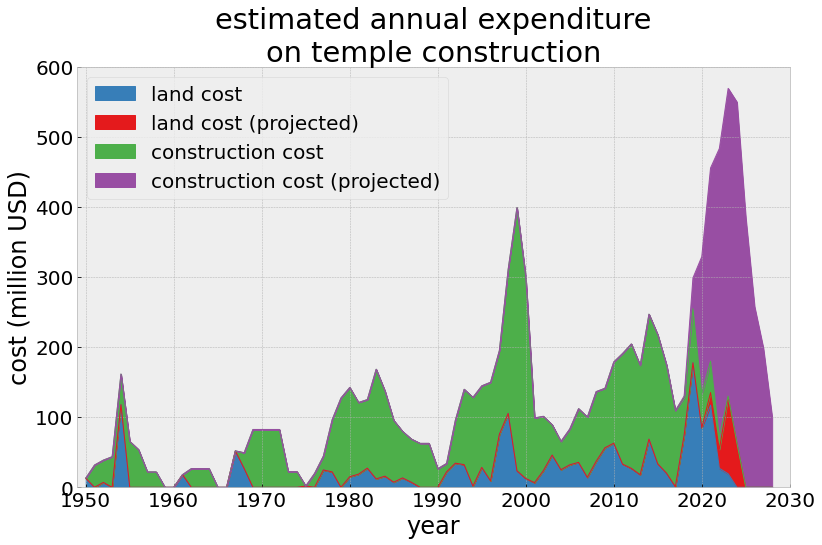

In [10]:
# stacked area graph of the 4 components of the total
ax = (yearly_total[['land cost', 'land cost (projected)',
                    'construction cost', 'construction cost (projected)']]/1e6).plot.area(
    title='estimated annual expenditure\non temple construction',
    stacked=True,
    ylabel='cost (million USD)',
    xlabel='year',
    xlim=[1949, 2030],
    ylim=[0, 600], lw=1)

To compare this total to the church's annual operating costs (in 2021 dollars), we use $7 billion as an estimate of the operating costs of the church. At that number, temple construction has been about 2-3% of annual operating costs since 2000, but briefly went as high as 5% in 1999. The current construction boom appears that it will take temple construction as high as 8% of annual operating expenses in the coming years.

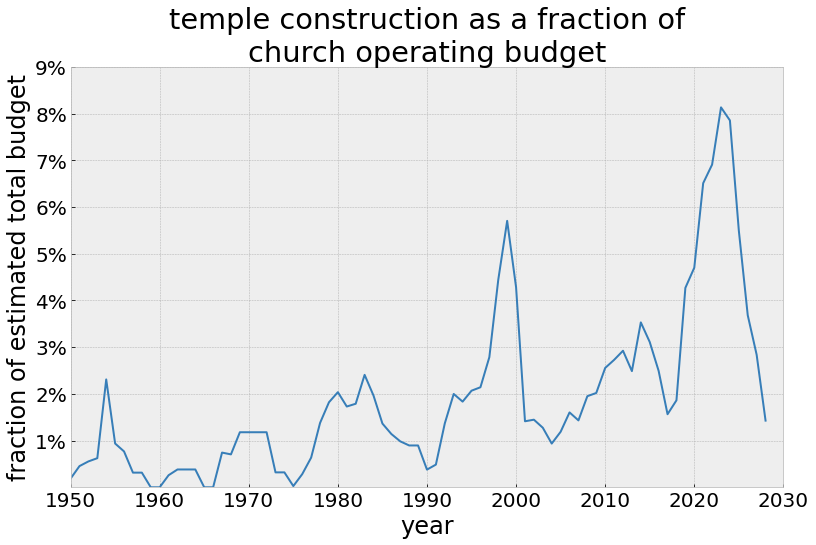

In [11]:
(yearly_total['total cost']/7e9*100).plot(
    title='temple construction as a fraction of\nchurch operating budget',
    xlabel='year',
    ylabel='fraction of estimated total budget',
    ylim=[0, None],
    xlim=[1950, 2030])
yt = range(1, 10)
_ = pl.yticks(yt, [str(x)+'%' for x in yt])

## Temples vs. membership
To put current and past temple construction activity into context it is helpful to compare temples to membership. First, we look at raw numbers. The chart below makes it clear that the current surge in temple building activity isn't the first one. After a long period of temples being built one or two at a time, there were two previous periods of high construction activity. The first was a flurry of temples announced by Spencer W. Kimball that were completed in the mid-1980s, some of them after his death. Gordon B. Hinckley famously announced in a general conference in 1999 his intention to build a large number of new smaller temples. Those new temples were completed over the next 2-3 years and then construction reverted to normal levels. Russell M. Nelson started announcing temples at a faster rate when he became president of the church, and continues to do so at a fast pace. The temples he announced are starting to be completed in 2022, so 2022 marks the start of the "Nelson surge" on the chart, with projected completion dates in the future for the announced temples. The Nelson surge is a much larger number of temples over a more prolonged period of time.

In [12]:
# calculate how many temples were using filmed endowment presentation
ef = td[['Name', 'Dedication date']].copy()
#ef['Dedication']<'1950-01-01'
film_era = ef['Dedication date']>'1950-01-01'
ef.loc[film_era, 'film_start'] = ef[film_era]['Dedication date']

conversion_dates = [
    ['St. George Utah Temple', '1975-11-11'],
    ['Logan Utah Temple', '1979-03-13'],
    ['Manti Utah Temple', '2025-01-01'],
    ['Salt Lake Temple', '2025-01-01'],
    ['Laie Hawaii Temple', '1978-06-13'],
    ['Cardston Alberta Temple', '1991-03-22'], # rededication date, seems later than the others
    ['Mesa Arizona Temple', '1975-04-16'],
    ['Idaho Falls Idaho Temple', '1975-01-01'] # no exact date on this one
]

for temple, date in conversion_dates:
    ef.loc[ef['Name']==temple, 'film_start'] = date
ef = ef.sort_values('Dedication date')
ef['total'] = np.arange(len(ef)) + 1
ef['film'] = 0
for idx, row in ef.iterrows():
    ef.loc[idx, 'film'] = (ef.loc[:idx, 'film_start']<=row['Dedication date']).sum()
ef['film_frac'] = ef['film']/ef['total']
#ef.plot(x='Dedication date', y='film_frac')

In [13]:
bg_shade = '#d7d7e7'
kimball_temples = ('1983-01-01', '1987-01-01')
hinckley_temples = ('1999-01-01', '2002-01-01')
nelson_temples = ('2022-01-01', '2029-07-01')
filmed_endowment_transition = (ef[ef['film_frac']<=0.15].iloc[-1]['Dedication date'],
                               ef[ef['film_frac']>=0.9].iloc[0]['Dedication date'])

def dateinterp(dates, r):
    a, b = [np.datetime64(val) for val in dates]
    return a + (b-a)*r

def add_bg(ax, bg='fkh', text=True, yvals={}):
    y_pos = lambda y: np.inner(ax.get_ylim(), (1-y, y))
    y_vals = {key:y_pos(0.05) for key in ('f', 'k', 'h', 'n')}
    y_vals.update(yvals)

    if 'f' in bg:
        ax.axvspan(*filmed_endowment_transition, color='#d7f7d7')
        if text:
            ax.annotate('transition to\nfilmed\nendowment', ('1958-01-01', y_vals['f']),
                        size='x-small', ha='left', va='bottom')
    if 'k' in bg:
        ax.axvspan(*kimball_temples, color=bg_shade)
        if text:
            ax.annotate('Kimball surge',
                        (dateinterp(kimball_temples, 0.7), y_vals['k']),
                        size='x-small', ha='center', va='bottom', rotation=90)
    if 'h' in bg:
        ax.axvspan(*hinckley_temples, color=bg_shade)
        if text:
            ax.annotate('Hinckley surge',
                        (dateinterp(hinckley_temples, 0.7), y_vals['h']),
                        size='x-small', ha='center', va='bottom', rotation=90)
    if 'n' in bg:
        ax.axvspan(*nelson_temples, color=bg_shade, zorder=0)
        if text:
            ax.annotate('Nelson surge',
                        (dateinterp(nelson_temples, 0.7), y_vals['n']),
                        size='x-small', ha='right', va='bottom', rotation=90)

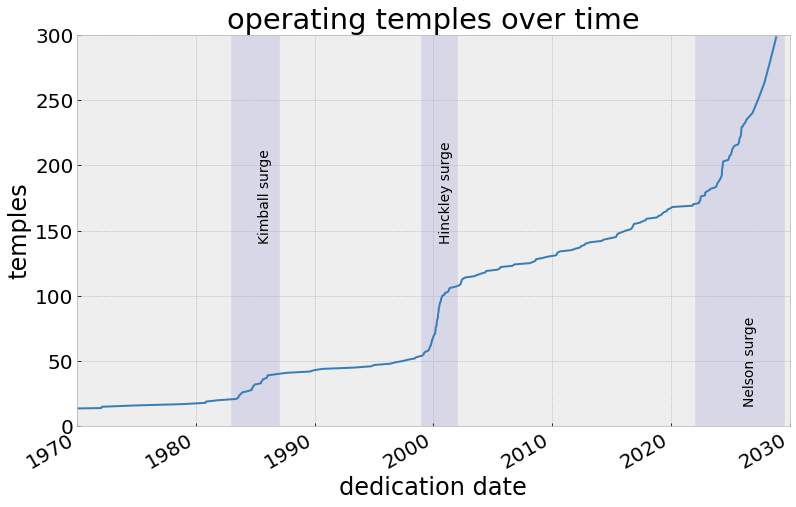

In [14]:
ax = td_.groupby('Dedication date').size().sort_index().cumsum().plot(
    xlim=['1970-01-01', '2030-01-01'], ylim=[0, 300],
    title='operating temples over time',
    ylabel='temples',
    xlabel='dedication date')
add_bg(ax, 'khn', yvals={'k': 140, 'h': 140})

The other important thing to consider when comparing temples to membership is the efficiency in space usage that resulted from the filmed endowment presentation. The filmed endowment was introduced in the 1950s with the construction of new temples in England, Switzerland, and New Zealand. All new temples built after that time used the filmed endowment, and many of the historic temples switched to filmed endowment when they underwent renovations in the late 20th century. The chart below shows the progress of the transition by illustrating the fraction of temples over time that were using filmed endowments. Rededications of historic temples were considered transition dates. Using those calculations it is apparent that the way temples were used went through its most significant change between roughly the mid 1950s and mid 1980s as the fraction of operating temples using the filmed endowment went from 10% of the total to 90% of the total.

In [15]:
area_time = td_[['Dedication date','area']].sort_values('Dedication date')
area_time['total area (million sq ft)'] = area_time['area'].cumsum()/1e6
area_time['number'] = area_time.reset_index().index+1
#area_time.plot(x='Dedication date', y=['total area (million sq ft)'],
#               xlim=['1970-01-01', '2030-01-01'], ylim=[0, None],
#               ylabel='area (million sq. ft.)', legend=False)

area_time['year'] = area_time['Dedication date'].dt.year
year_end_vals = area_time.groupby('year')[['total area (million sq ft)', 'number']].max()

ym_tmp = year_end_vals.merge(
    md, left_index=True, right_on='Year', how='outer').sort_values('Year')
ym_tmp['date'] = pd.to_datetime(ym_tmp['Year'].apply(lambda x: f'{x+1}-01-01'))
# worst case growth: 0
last_idx = ym_tmp['Membership'].idxmax()
last_mem_val = ym_tmp.loc[last_idx]['Membership']
ym_tmp.loc[last_idx:, 'Membership (min)'] = last_mem_val
# best case growth: last 20 years
ref_mem_vals = ym_tmp[ym_tmp['Year'].between(2000,2021)]['Membership']
growth_factor = np.mean(ref_mem_vals.values[1:]/ref_mem_vals.values[:-1])
proj_years = ym_tmp.loc[last_idx:]['Year']
proj_mem = (last_mem_val * growth_factor**(proj_years - proj_years.iloc[0])).round(0)
ym_tmp.loc[last_idx:, 'Membership (max)'] = proj_mem

ym = ym_tmp[ym_tmp['Year']>=1877].copy()
ym['area'] = ym['total area (million sq ft)'].fillna(method='ffill')*1e6
ym['number'] = ym['number'].fillna(method='ffill').astype(int)

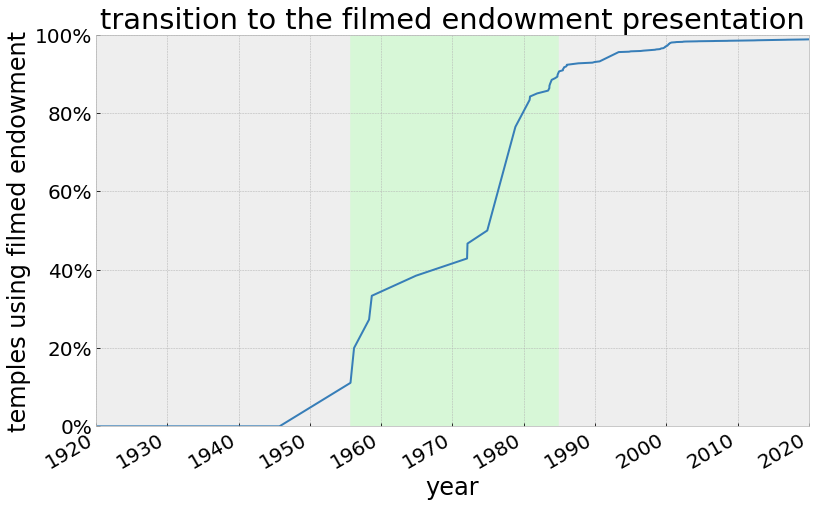

In [16]:
ax1 = ef.plot(x='Dedication date', y='film_frac', ylim=[0, 1],
              xlabel='year',
              ylabel='temples using filmed endowment',
              title='transition to the filmed endowment presentation',
              yticks=np.linspace(0, 1, 6),
              legend=False,
              xlim=['1920-01-01', '2020-01-01'])
ax1.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
add_bg(ax1, 'f', False)

m_t = ym[['Membership', 'Membership (min)', 'Membership (max)']].divide(ym['number'], 0)
m_t.index = ym['date']
m_t.columns = ['historical', 'projected (min)', 'projected (max)']
#ax2 = m_t[['historical']].plot(xlabel='year', ylim=[0, None], legend=False)
#add_bg(ax2)

m_a = ym[['Membership', 'Membership (min)', 'Membership (max)']].divide(ym['area'], 0)
m_a.index = ym['date']
m_a.columns = ['historical', 'projected (min)', 'projected (max)']
#ax3 = m_a[['historical']].plot(ylabel='members per square foot',
#                               xlabel='year', ylim=[0, 3], legend=False)
#add_bg(ax3)

With that context, the chart below shows the church membership per square foot of operating temple space over time. The region at the right of the graph is based on best and worst case projections for membership growth. Best case growth is a continuation of growth rates since 2000, worst case is membership stays at 2022 levels for the rest of the decade.

We can see two distinct eras in the data. Pre-1950, there were roughly 1.0 (or fewer) church members per square foot of temple space. During the transition phase where the filmed endowment was introduced, this number increases significantly, reaching a new level around 2.5 members per square foot. This number was able to increase because the filmed endowment made more efficient use of space in the temples. Remarkably, that number stayed relatively stable between 2.5 and 3.0 members per square foot up to 2020, through the surges in construction activity in the Kimball and Hinckley eras. Those construction surges mainly had the effect of keeping up with membership growth more than anything else.

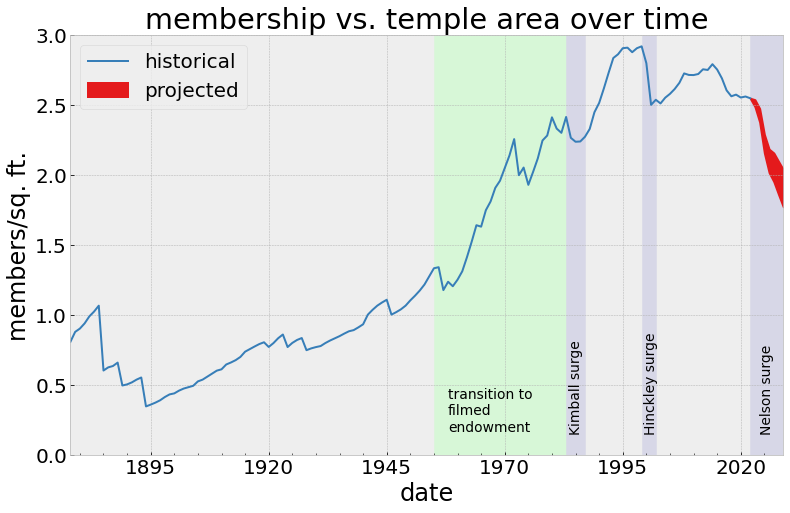

In [17]:
lw_default=2
#ax1 = m_t['historical'].plot(ylim=[0, None])
#ax1.fill_between(m_t.index, m_t['projected (min)'], m_t['projected (max)'],
#                 color=clist[1], lw=lw_default)
#ax1.legend(['historical', 'projected'], loc='upper left')
#add_bg(ax1, 'fkhn', yval=0.65)

pl.figure()
ax2 = m_a['historical'].plot(ylabel='members/sq. ft.', ylim=[0, 3],
                            title='membership vs. temple area over time')
ax2.fill_between(m_a.index, m_a['projected (min)'], m_a['projected (max)'],
                 color=clist[1], lw=lw_default)
ax2.legend(['historical', 'projected'], loc='upper left')
add_bg(ax2, 'fkhn')

In [18]:
#total_area = td['area'].sum()
#total_area, total_area*2.5
## result: 9.5M sq ft, 24M members

The new construction boom under President Nelson is projected to take us, by the end of the 2020s, into a new era where the membership relative to temple space is at levels not seen since the 1970s when a majority of temples were using live actors to present the endowment. At historical temple usage levels (2.5 members per square feet), the estimated 9.5 million square feet of announced temple capacity would be enough to serve nearly 24 million members, a number that the church is not likely to reach any time soon.

This has various significant possible implications for the future. We can expect many of the temples, especially in areas with low membership population, to have relatively sparse schedules. It's possible this is a deliberate choice, bringing temples close to people with the understanding that not all of them will be open with a full schedule every day of the week. A second implication is that there will be an expectation from members to use the temples, and to help staff the temlpes. We can likely expect an increase of messaging in general conference on this subject over the next decade.

In [19]:
# Setup show/hide source code box
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="show/hide source code"></form>''')